
<h3 style="text-align: center;"><b>На основе ШАД Яндекс</b></h3><h1 id="Домашнее-задание.-Обучение-нейронных-сетей-на-PyTorch.">Домашнее задание. Обучение нейронных сетей на PyTorch.<a class="anchor-link" href="#Домашнее-задание.-Обучение-нейронных-сетей-на-PyTorch.">¶</a></h1><p>В этом домашнем задании вам предстоит предсказывать типы небесных объектов. Эту задачу вы будете решать с помощью нейронных сетей, используя библиотеку PyTorch.</p>
<p>Вам необходимо заполнить пропуски в ноутбуке. Кое-где вас просят сделать выводы о проделанной работе. Постарайтесь ответить на вопросы обдуманно и развёрнуто.</p>


In [1]:

import torch
from torch import nn
from torch import functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt




<h1 id="Дисклеймер-про-CrossEntropyLoss-и-NLLLoss">Дисклеймер про CrossEntropyLoss и NLLLoss<a class="anchor-link" href="#Дисклеймер-про-CrossEntropyLoss-и-NLLLoss">¶</a></h1><p>Обычно в PyTorch не нужно делать Softmax как последний слой модели.</p>
<ul>
<li>Если Вы используете NLLLoss, то ему на вход надо давать лог вероятности, то есть выход слоя LogSoftmax. (Просто результат софтмакса, к которому применен логарифм)</li>
<li>Если Вы используете CrossEntropyLoss, то применение LogSoftmax уже включено внутрь лосса, поэтому ему на вход надо подавать просто выход обычного линейного слоя без активации. По сути CrossEntropyLoss = LogSoftmax + NLLLoss</li>
</ul>
<p>Зачем такие сложности, чтобы посчитать обычную кросс энтропию? Дело в том, что нам в любом случае придется взять логарифм от результатов софтмакса, а если делать это одной функцией, то можно сделать более устойчивую реализацию, которая даст меньшую вычислительную погрешность.</p>
<p>Таким образом, если у вас в конце сети, решающей задачу классификации, стоит просто линейный слой без активации, то вам нужно использовать CrossEntropy. В этой домашке везде используется лосс CrossEntropy</p>



<h1 id="Задание-1.-Создайте-генератор-батчей.">Задание 1. Создайте генератор батчей.<a class="anchor-link" href="#Задание-1.-Создайте-генератор-батчей.">¶</a></h1><p>В этот раз мы хотим сделать генератор, который будет максимально похож на то, что используется в реальном обучении.</p>
<p>С помощью numpy вам нужно перемешать исходную выборку и выбирать из нее батчи размером batch_size, если размер выборки не делился на размер батча, то последний батч должен иметь размер меньше batch_size и состоять просто из всех оставшихся объектов. Возвращать нужно в формате (X_batch, y_batch). Необходимо написать именно генератор, то есть вместо return использовать yield.</p>
<p>Хорошая статья про генераторы: <a href="https://habr.com/ru/post/132554/">https://habr.com/ru/post/132554/</a></p>
<p><strong>Ответ на задание - код</strong></p>


In [2]:
import random
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    #print(perm)
    # YOUR CODE
    num_samples = len(perm)
    
    for offset in range(0, num_samples, batch_size):
        batch_samples = perm[offset:offset+batch_size]
        
        
        X_train = np.array(X[batch_samples])
        y_train = np.array(y[batch_samples])
       

         
        #print(X_train, y_train)
        yield X_train, y_train
        
        
        



<p>Попробуем потестировать наш код</p>


In [3]:

from inspect import isgeneratorfunction
assert isgeneratorfunction(batch_generator), "batch_generator должен быть генератором! В условии есть ссылка на доки"

X = np.array([
              [1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]
])
y = np.array([
              1, 2, 3
])

# Проверим shape первого батча
iterator = batch_generator(X, y, 2)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (2, 3)
assert y_batch.shape == (2,)
assert np.allclose(X_batch, X[:2]), np.allclose(y_batch, y[:2])

# Проверим shape последнего батча (их всего два)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (1, 3), y_batch.shape == (1,)
assert np.allclose(X_batch, X[2:]), np.allclose(y_batch, y[2:])

# Проверим, что итерации закончились
iter_ended = False
try:
    next(iterator)
except StopIteration:
    iter_ended = True
print(iter_ended)
assert iter_ended

# Еще раз проверим то, сколько батчей создает итератор
X = np.random.randint(0, 100, size=(1000, 100))
y = np.random.randint(-1, 1, size=(1000, 1))
num_iter = 0
for _ in batch_generator(X, y, 3):
    num_iter += 1
assert num_iter == (1000 // 3 + 1)



True



<h1 id="Задание-2.-Обучите-модель-для-классификации-звезд">Задание 2. Обучите модель для классификации звезд<a class="anchor-link" href="#Задание-2.-Обучите-модель-для-классификации-звезд">¶</a></h1><p>Загрузите датасет из файла sky_data.csv, разделите его на train/test и обучите на нем нейронную сеть (архитектура ниже). Обучайте на батчах с помощью оптимизатора Adam, lr подберите сами, пробуйте что-то вроде 1e-2</p>
<p>Архитектура:</p>
<ol>
<li>Dense Layer с relu активацией и 50 нейронами</li>
<li>Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%) </li>
<li>BatchNorm</li>
<li>Dense Layer с relu активацией и 100 нейронами</li>
<li>Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)</li>
<li>BatchNorm</li>
<li>Выходной Dense слой c количеством нейронов, равному количеству классов</li>
</ol>
<p>Лосс - CrossEntropy.</p>



<p>В датасете классы представлены строками, поэтому классы нужно закодировать. Для этого в строчке ниже объявлен dict, с помощью него и функции map превратите столбец с таргетом в целое число. Кроме того, за вас мы выделили признаки, которые нужно использовать.</p>



<h3 id="Загрузка-и-обработка-данных">Загрузка и обработка данных<a class="anchor-link" href="#Загрузка-и-обработка-данных">¶</a></h3>


In [4]:

feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field']
target_column = 'class'

target_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}



In [5]:
#data = pd.read_csv('https://drive.google.com/uc?id=1K-8CtATw6Sv7k2dXco1fL5MAhTbKtIH3')
data = pd.read_csv('sky_data.csv')
data['class'].value_counts()



GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [6]:

data.head()



,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [7]:
data['class']

0         STAR
1         STAR
2       GALAXY
3         STAR
4         STAR
         ...  
9995    GALAXY
9996    GALAXY
9997      STAR
9998    GALAXY
9999    GALAXY
Name: class, Length: 10000, dtype: object

In [8]:
def encode_(n):
    return target_mapping[n]

In [9]:

# Extract Features
X = data[feature_columns]
# Extract target
y = data[target_column]

# encode target with target_mapping
y = list(map(encode_,y))




<p>Нормализация фичей</p>


In [13]:

# Просто вычтите среднее и поделитe на стандартное отклонение (с помощью пандас). Также преобразуйте всё в np.array
X = np.array((X-X.mean())/X.std())
y= np.array(y)
type(X)


numpy.ndarray

In [16]:

assert type(X) == np.ndarray and type(y) == np.ndarray, 'Проверьте, что получившиеся массивы являются np.ndarray'
assert np.allclose(y[:5], [1,1,0,1,1])
assert X.shape == (10000, 10)
assert np.allclose(X.mean(axis=0), np.zeros(10)) and np.allclose(X.std(axis=0), np.ones(10)), 'Данные не отнормированы'




<p>Обучение</p>


In [17]:

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)



In [18]:
X_train.shape

torch.Size([7500, 10])


<p>Хорошо, данные мы подготовили, теперь надо объявить модель</p>


In [39]:

torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(10, 50),  #10 - признаки
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(50),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(100),
    nn.Linear(100, 3)   # 3  выход ответа
)
    

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



<h3 id="Обучающий-цикл">Обучающий цикл<a class="anchor-link" href="#Обучающий-цикл">¶</a></h3>


In [40]:

def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        epoch_train_losses = []
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            # Посчитаем предсказание и лосс
            # YOUR CODE
            
            
            X_batch = torch.from_numpy(X_batch)
            y_batch = torch.from_numpy(y_batch)
            #data = data.view(data.size(0), -1)
            X_batch = X_batch.view(X_batch.size(0), -1)
            #y_batch = np.argmax(y_batch,axis=0)
            #y_batch = torch.max(y_batch, 1)[1]
            #print(X_batch.size())
            y_pred = model(X_batch)
            #print(y_pred.size(), y_batch[i])
            loss = loss_fn(y_pred, y_batch)
    
            # зануляем градиент
            # YOUR CODE
            optimizer.zero_grad()
            # backward
            # YOUR CODE
            loss.backward()
            # ОБНОВЛЯЕМ веса
            # YOUR CODE
            optimizer.step()
            
            
            
            
            
            
            
            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_losses.append(loss.item())
        if i%30==0:
            print("# {} epoch, loss: {}".format(i, loss.data))
            print("")
        train_losses.append(np.mean(epoch_train_losses))
        
        # Теперь посчитаем лосс на тесте
        model.train(False)
        with torch.no_grad():
            # Сюда опять же надо положить именно число равное лоссу на всем тест датасете
            loss_test = loss_fn(model(X_test), y_test)
            test_losses.append(loss_test)
            
    return train_losses, test_losses



In [41]:

def check_loss_decreased():
    print("На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]")
    s = input()
    if s.lower() == 'да':
        print("Хорошо!")
    else:
        raise RuntimeError("Можно уменьшить дропаут, уменьшить lr, поправить архитектуру, etc")



# 0 epoch, loss: 1.2039129734039307

# 30 epoch, loss: 0.8217111229896545

# 60 epoch, loss: 0.7055836915969849

# 90 epoch, loss: 0.6402140259742737

# 120 epoch, loss: 0.5646721124649048

# 150 epoch, loss: 0.5058687329292297

# 180 epoch, loss: 0.4520599842071533

# 210 epoch, loss: 0.3675367832183838

# 240 epoch, loss: 0.378989040851593

# 270 epoch, loss: 0.3446439206600189

# 300 epoch, loss: 0.3408896327018738

# 330 epoch, loss: 0.33344629406929016

# 360 epoch, loss: 0.3242943584918976

# 390 epoch, loss: 0.3189094364643097

# 420 epoch, loss: 0.2726307809352875

# 450 epoch, loss: 0.26796847581863403

# 480 epoch, loss: 0.28654128313064575



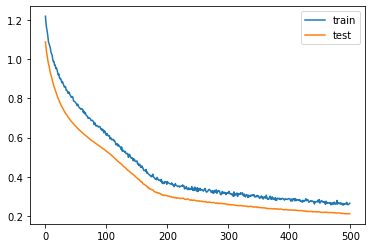

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
да
Хорошо!


In [42]:

train_losses, test_losses = train(X_train, y_train, X_test, y_test, 500) #Подберите количество эпох так, чтобы график loss сходился
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3




<h3 id="Вычислите-accuracy-получившейся-модели-на-train-и-test">Вычислите accuracy получившейся модели на train и test<a class="anchor-link" href="#Вычислите-accuracy-получившейся-модели-на-train-и-test">¶</a></h3>


In [45]:

from sklearn.metrics import accuracy_score

model.eval()
train_pred_labels = model(X_train).argmax(dim=1)
test_pred_labels = model(X_test).argmax(dim=1)

train_acc = accuracy_score(y_train, train_pred_labels)
test_acc = accuracy_score(y_test, test_pred_labels)

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))



Train accuracy: 0.9426666666666667
Test accuracy: 0.9412



<h1 id="Задание-3.-Исправление-ошибок-в-архитектуре">Задание 3. Исправление ошибок в архитектуре<a class="anchor-link" href="#Задание-3.-Исправление-ошибок-в-архитектуре">¶</a></h1><p>Только что вы обучили полносвязную нейронную сеть. Теперь вам предстоит проанализировать архитектуру нейронной сети ниже, исправить в ней ошибки и  обучить её с помощью той же функции train. Пример исправления ошибок есть в семинаре Григория Лелейтнера.</p>
<p>Будьте осторожнее и убедитесь, что перед запуском train вы вновь переопределили все необходимые внешние переменные (train обращается к глобальным переменным, в целом так делать не стоит, но сейчас это было оправдано, так как иначе нам пришлось бы передавать порядка 7-8 аргументов).</p>
<p>Чтобы у вас получилась такая же архитектура, как у нас, и ответы совпали, давайте определим некоторые правила, как исправлять ошибки:</p>
<ol>
<li>Если вы видите лишний нелинейный слой, который стоит не на своем месте, просто удалите его. (не нужно добавлять новые слои, чтобы сделать постановку изначального слоя разумной. Удалять надо самый последний слой, который все портит. Для линейных слоев надо что-то исправить, а не удалить его)</li>
<li>Если у слоя нет активации, то добавьте ReLU или другую подходящую активацию</li>
<li>Если что-то не так с learning_rate, то поставьте 1e-2</li>
<li>Если что-то не так с параметрами, считайте первый параметр, который появляется, как верный (т.е. далее в сети должен использоваться он).</li>
<li>Ошибки могут быть и в полносвязных слоях. </li>
<li>Любые другие проблемы решаются более менее однозначно, если же у вас есть серьезные сомнения, то напишите в беседу в телеграме и пинганите меня @AlexPak</li>
</ol>



<p>Задача все та же - классификация небесных объектов на том же датасете. После исправления сети вам нужно обучить ее.</p>
<p><strong>Ответ на задачу - средний лосс на тестовом датасете</strong></p>


In [47]:

torch.manual_seed(42)   
np.random.seed(42)
# WRONG ARCH
model = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(6, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 200),
    nn.Softmax(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
    nn.Dropout(p=0.5)
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters[:-2], lr=1e-100)



TypeError: 'method' object is not subscriptable

In [50]:

# RIGHT ARCH
torch.manual_seed(42)   
np.random.seed(42)
model = nn.Sequential(
    
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(50, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
    
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)




<h3 id="Обучите-и-протестируйте-модель-так-же,-как-вы-это-сделали-в-задаче-2.-Вычислите-accuracy.">Обучите и протестируйте модель так же, как вы это сделали в задаче 2. Вычислите accuracy.<a class="anchor-link" href="#Обучите-и-протестируйте-модель-так-же,-как-вы-это-сделали-в-задаче-2.-Вычислите-accuracy.">¶</a></h3>


# 0 epoch, loss: 0.900601327419281

# 30 epoch, loss: 0.33422064781188965

# 60 epoch, loss: 0.22680988907814026

# 90 epoch, loss: 0.20050297677516937

# 120 epoch, loss: 0.18601199984550476

# 150 epoch, loss: 0.17619821429252625

# 180 epoch, loss: 0.1518436223268509

# 210 epoch, loss: 0.1705247461795807

# 240 epoch, loss: 0.14908967912197113

# 270 epoch, loss: 0.15467683970928192

# 300 epoch, loss: 0.1083013266324997

# 330 epoch, loss: 0.16339702904224396

# 360 epoch, loss: 0.1519934982061386

# 390 epoch, loss: 0.13290780782699585

# 420 epoch, loss: 0.13392610847949982

# 450 epoch, loss: 0.09508363902568817

# 480 epoch, loss: 0.14819276332855225



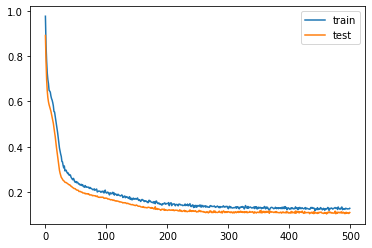

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
Да
Хорошо!


In [51]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, 500) #Подберите количество эпох так, чтобы график loss сходился
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3


In [52]:

#YOUR CODE

model.eval()
train_pred_labels = model(X_train).argmax(dim=1)
test_pred_labels = model(X_test).argmax(dim=1)

train_acc = accuracy_score(y_train, train_pred_labels)
test_acc = accuracy_score(y_test, test_pred_labels)

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))




Train accuracy: 0.9728
Test accuracy: 0.9664



<h2 id="Задание-4.-Сделайте-выводы">Задание 4. Сделайте выводы<a class="anchor-link" href="#Задание-4.-Сделайте-выводы">¶</a></h2><p>Начиная с какого количества блоков минимальный лосс за время обучения увеличивается? Почему лишнее количество блоков не помогает модели?</p>
